# Практика №7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iapws.iapws97 import IAPWS97 as gas

from typing import Any, Union, Optional, Tuple

### Вспомогательные функции

In [3]:
def check_same_size(a: np.ndarray, b: np.ndarray) -> None:
    if a.shape != b.shape:
        raise ValueError("Size of arrays should be the same!")

In [9]:
variable_1 = np.array([1, 2, 3])
variable_2 = np.array([2, 3, 5, 9])
variable_3 = np.array([2, 3, 9])

In [10]:
check_same_size(variable_1, variable_2)

ValueError: Size of arrays should be the same!

In [12]:
check_same_size(variable_1, variable_3) # Не упала так как размеры одинаковы

In [4]:
def check_valid_types(a: Any) -> None:
    if not isinstance(a, (int, float, np.ndarray)):
        raise ValueError(f"Variable have type {type(a)} that is not allowed!")

In [15]:
# Не упали так как типы позволительны
check_valid_types(12)
check_valid_types(324.23)
check_valid_types(variable_1)

In [16]:
check_valid_types("hehe")

ValueError: Variable have type <class 'str'> that is not allowed!

In [17]:
check_valid_types(gas(P=1, T=500))

ValueError: Variable have type <class 'iapws.iapws97.IAPWS97'> that is not allowed!

In [6]:
def uproll_var(a: Union[int, float], a_like: np.ndarray) -> np.ndarray:
    return np.ones_like(a_like) * a

In [18]:
uproll_var(34, variable_1)

array([34, 34, 34])

In [19]:
uproll_var(34, variable_2)

array([34, 34, 34, 34])

In [7]:
def preprocess_args(*args) -> Any:
    is_digits = dict()
    is_arrays = dict()
    for i, val in enumerate(args):
        check_valid_types(val)
        if isinstance(val, (int, float)):
            is_digits[i] = val
        else:
            is_arrays[i] = val
    if len(is_arrays) > 1:
        vals = list(is_arrays.values())
        for left, right in zip(vals[:-1], vals[1:]):
            check_same_size(left, right)
    if len(is_arrays) == 0:
        return [np.array([val]) for val in args]
    a_like = list(is_arrays.values())[0]
    for key, values in is_digits.items():
        is_digits[key] = uproll_var(a=values, a_like=a_like)
    is_digits.update(is_arrays)
    to_return = [is_digits[i] for i in range(len(args))]
    return to_return   

In [20]:
preprocess_args(1, 2, 3)

[array([1]), array([2]), array([3])]

In [21]:
preprocess_args(1, 2, variable_3)

[array([1, 1, 1]), array([2, 2, 2]), array([2, 3, 9])]

In [23]:
preprocess_args(1, variable_1, variable_3)

[array([1, 1, 1]), array([1, 2, 3]), array([2, 3, 9])]

In [24]:
preprocess_args(variable_2, variable_1, variable_3)

ValueError: Size of arrays should be the same!

## Вспомогательное по газу

### Атомарные функции

In [25]:
MPa = 1e6

default_types = Union[int, float, np.ndarray]


def get_p_from_h_s(h: default_types, s: default_types) -> np.ndarray:
    h, s = preprocess_args(h, s)
    p = np.array([gas(h=_h / 1000, s=_s).P * MPa for _h, _s in zip(h, s)])
    return p

def get_v_from_h_s(h: default_types, s: default_types) -> np.ndarray:
    h, s = preprocess_args(h, s)
    v = np.array([gas(h=_h / 1000, s=_s).v for _h, _s in zip(h, s)])
    return v

def get_t_from_h_s(h: default_types, s: default_types) -> np.ndarray:
    h, s = preprocess_args(h, s)
    t = np.array([gas(h=_h / 1000, s=_s).T for _h, _s in zip(h, s)])
    return t

def get_h_from_p_s(p: default_types, s: default_types) -> np.ndarray:
    p, s = preprocess_args(p, s)
    h = np.array([gas(P=_p / MPa, s=_s).h * 1000 for _p, _s in zip(p, s)])
    return h

def get_h_from_p_t(p: default_types, t: default_types) -> np.ndarray:
    p, t = preprocess_args(p, t)
    h = np.array([gas(P=_p / MPa, T=_t).h * 1000 for _p, _t in zip(p, t)])
    return h

def get_s_from_p_h(p: default_types, h: default_types) -> np.ndarray:
    p, h = preprocess_args(p, h)
    s = np.array([gas(P=_p / MPa, h=_h/1000).s for _p, _h in zip(p, h)])
    return s

def get_s_from_p_t(p: default_types, t: default_types) -> np.ndarray:
    p, t = preprocess_args(p, t)
    s = np.array([gas(P=_p / MPa, T=_t).s for _p, _t in zip(p, t)])
    return s

def get_a_from_h_s(h: default_types, s: default_types) -> np.ndarray:
    h, s = preprocess_args(h, s)
    a = np.array([gas(h=_h / 1000, s=_s).w for _h, _s in zip(h, s)])
    return a

In [34]:
p = np.array([1 * MPa, 2 * MPa, 3 * MPa])
h = get_h_from_p_t(p=p, t=500)
h

array([2891276.56463551, 2841381.55846902,  975542.23909723])

In [35]:
s = get_s_from_p_h(p=p, h=h)
s

array([6.82505291, 6.42645407, 2.58041912])

In [30]:
get_a_from_h_s(h=h, s=s)

array([ 535.66670756,  518.7901906 , 1240.7133731 ])

### Расширяемые функции для термодинамической величины

In [31]:
def get_p_from_state(
    h: Optional[default_types] = None,
    s: Optional[default_types] = None,
) -> np.ndarray:
    if h is not None and s is not None:
        return get_p_from_h_s(h, s)
    
    raise KeyError("Wrong arguments combination!")

def get_v_from_state(
    h: Optional[default_types] = None,
    s: Optional[default_types] = None,
) -> np.ndarray:
    if h is not None and s is not None:
        return get_v_from_h_s(h, s)
    
    raise KeyError("Wrong arguments combination!")

def get_t_from_state(
    h: Optional[default_types] = None,
    s: Optional[default_types] = None,
) -> np.ndarray:
    if h is not None and s is not None:
        return get_t_from_h_s(h, s)
    
    raise KeyError("Wrong arguments combination!")


def get_s_from_state(
    p: Optional[default_types] = None,
    h: Optional[default_types] = None,
    t: Optional[default_types] = None,
) -> np.ndarray:
    if p is not None and h is not None:
        return get_s_from_p_h(p, h)
    if p is not None and t is not None:
        return get_s_from_p_t(p, t)

    raise KeyError("Wrong arguments combination!")

def get_h_from_state(
    p: Optional[default_types] = None,
    s: Optional[default_types] = None,
    t: Optional[default_types] = None,
) -> np.ndarray:
    if p is not None and s is not None:
        return get_h_from_p_s(p, s)
    if p is not None and t is not None:
        return get_h_from_p_t(p, t)

    raise KeyError("Wrong arguments combination!")


def get_sound_speed_from_state(
    h: Optional[default_types] = None,
    s: Optional[default_types] = None,
) -> np.ndarray:
    if h is not None and s is not None:
        return get_a_from_h_s(h, s)
    
    raise KeyError("Wrong arguments combination!")


In [32]:
get_sound_speed_from_state(h=h, s=s)

array([ 535.66670756,  518.7901906 , 1240.7133731 ])

In [36]:
get_h_from_state(p=p, s=s)

array([2891276.56463551, 2841381.55846902,  975542.23909722])

In [37]:
get_h_from_state(p=p, t=500)

array([2891276.56463551, 2841381.55846902,  975542.23909723])

## Расчет ступени

In [42]:
p0 = 2.3 * MPa
t0 = 500 + 273.15
p2 = 2 * MPa
n = 50
d = 1
G = 100
dl = 0.003
alpha_1_eff = np.deg2rad(13)
degree_of_reaction = 0.1
inlet_speed = 0
degree_of_reaction = np.arange(0, 0.9, 0.05)
p0 = np.ones_like(degree_of_reaction) * 2.3 * MPa

is_last = True

In [43]:
def compute_total_heat_drop(
    p0: default_types,
    t0: default_types,
    p2: default_types,
    inlet_speed: default_types,
) -> np.ndarray:
    inlet_energy = (inlet_speed ** 2) / 2
    s0 = get_s_from_state(p=p0, t=t0)
    _h0 = get_h_from_state(p=p0, s=s0)
    h0 = _h0 + inlet_energy
    h2t = get_h_from_state(p=p2, s=s0)

    total_heat_drop = h0 - h2t
    return total_heat_drop

def compute_heat_drops(
    p0: default_types,
    t0: default_types,
    p2: default_types,
    dor: default_types,
    inlet_speed: default_types,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    total_heat_drop = compute_total_heat_drop(p0=p0, t0=t0, p2=p2, inlet_speed=inlet_speed)
    stator_heat_drop = (1 - degree_of_reaction) * total_heat_drop
    rotor_heat_drop = total_heat_drop - stator_heat_drop
    
    return total_heat_drop, stator_heat_drop, rotor_heat_drop

def compute_intermedia_point(
    h_start: np.ndarray,
    s_start: np.ndarray,
    dH: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    h_end = h_start - dH
    p_end = get_p_from_state(h=h_end, s=s_start)
    v_end = get_v_from_state(h=h_end, s=s_start)
    t_end = get_t_from_state(h=h_end, s=s_start)
    return p_end, v_end, t_end, h_end

In [44]:
def compute_triangle(
    u: float,
    inlet_speed: default_types,
    inlet_angle: default_types
) -> Tuple[default_types, default_types]:   
    dependent_speed = (inlet_speed**2 + u**2 - 2 * inlet_speed * u * np.cos(inlet_angle)) ** 0.5
    outlet_angle = np.arccos((inlet_speed * np.cos(inlet_angle) - u) / dependent_speed)
    return dependent_speed, outlet_angle

In [45]:
def compute_speed_coefficient(
    blade_length: default_types,
    chord: default_types,
    is_rotor: bool
) -> float:
    if is_rotor:
        return 0.96 - 0.014 * chord / blade_length
    return 0.98 - 0.008 * chord / blade_length

def compute_discharge_coefficient(
    blade_length: default_types,
    chord: default_types,
    is_rotor: bool
) -> float:
    if is_rotor:
        return 0.965 - 0.010 * chord / blade_length
    return 0.982 - 0.005 * chord / blade_length

In [46]:
def compute_stator_blade_length(G, d, c1t, v1t, alpha_1, chord) -> float:
    is_solved = False
    nu = 1
    nu_new = None
    while not is_solved:
        if nu_new is not None:
            nu = nu_new
        blade_length = G * v1t / ((np.sin(alpha_1) * np.pi * d) * c1t * nu)
        nu_new = compute_discharge_coefficient(blade_length, chord, is_rotor=False)
        if np.isclose(nu, nu_new).all():
            is_solved = True
    return blade_length


def compute_beta_2(G, d, w2t, v2t, l2, nu) -> default_types:
    sin_beta_2 = G * v2t / (nu * w2t * np.pi * d * l2)
    return np.arcsin(sin_beta_2)


def move_angle(angle: default_types, speed_coefficient: float, discharge_coefficient: float) -> default_types:
    return np.arcsin(discharge_coefficient * np.sin(angle) / speed_coefficient)

In [47]:
def compute_blade_efficiency(
    G: float,
    d: float,
    p0: default_types,
    t0: default_types,
    p2: default_types,
    n: default_types,
    dl: float,
    alpha_1_eff: default_types,
    degree_of_reaction: default_types,
    is_last: bool,
    inlet_speed: default_types,
) -> default_types:
    
    chord = 50 / 1000

    u = np.pi * n * d

    total_heat_drop, stator_heat_drop, rotor_heat_drop = compute_heat_drops(
        p0=p0, t0=t0, p2=p2, dor=degree_of_reaction, inlet_speed=inlet_speed
    )
    h0 = get_h_from_p_t(p=p0, t=t0) + (inlet_speed ** 2) / 2
    s0 = get_s_from_p_h(p=p0, h=h0)
    p1, v1t, t1t, h1t = compute_intermedia_point(h0, s0, stator_heat_drop)
    
    c1t = (2 * stator_heat_drop) ** 0.5
    a = get_a_from_h_s(h1t, s0)
    mach_1t = c1t / a
    if (mach_1t > 1).any():
        raise RuntimeError("M1t > 1")
    
    l1 = compute_stator_blade_length(G, d, c1t, v1t, alpha_1_eff, chord)
    fi = compute_speed_coefficient(blade_length=l1, chord=chord, is_rotor=False)
    nu1 = compute_discharge_coefficient(blade_length=l1, chord=chord, is_rotor=False)
    alpha_1 = move_angle(alpha_1_eff, fi, nu1)
    
    c1 = fi * c1t
    w1, beta_1 = compute_triangle(u=u, inlet_speed=c1, inlet_angle=alpha_1)
    stator_loss = (c1t ** 2 - c1 ** 2) / 2
    
    h1 = h1t + stator_loss
    s1 = get_s_from_state(p=p1, h=h1)
    
    l2 = l1 + dl
    psi = compute_speed_coefficient(blade_length=l2, chord=chord, is_rotor=True)
    nu2 = compute_discharge_coefficient(blade_length=l2, chord=chord, is_rotor=True)
    _, v2t, t2t, h2t = compute_intermedia_point(h1, s1, rotor_heat_drop)
    w2t = (2 * rotor_heat_drop + w1 ** 2) ** 0.5
    
    a = get_a_from_h_s(h2t, s1)
    mach_2t = w2t / a
    if (mach_2t > 1).any():
        raise RuntimeError("M2t > 1")
    
    w2 = psi * w2t
    rotor_loss = (w2t ** 2 - w2 ** 2) / 2
    beta_2_eff = compute_beta_2(G=G, d=d, w2t=w2t, v2t=v2t, l2=l2, nu=nu2)
    beta_2 = move_angle(beta_2_eff, psi, nu2)
    
    c2, alpha_2 = compute_triangle(u=u, inlet_speed=w2, inlet_angle=beta_2)
    
    output_speed_loss = (c2 ** 2) / 2
    
    Lu = u * (c1 * np.cos(alpha_1) + c2 * np.cos(alpha_2))
    E = total_heat_drop - int(1 - is_last) * output_speed_loss
    blade_efficiency = Lu / E

    return blade_efficiency

In [48]:
degree_of_reaction = np.arange(0, 0.9, 0.05)
p0 = np.ones_like(degree_of_reaction) * 2.3 * MPa

eff = compute_blade_efficiency(
    G=G,
    d=d,
    p0=p0,
    t0=t0,
    p2=p2,
    dl=dl,
    degree_of_reaction=degree_of_reaction,
    n=n,
    alpha_1_eff=alpha_1_eff,
    inlet_speed=0,
    is_last=True
)

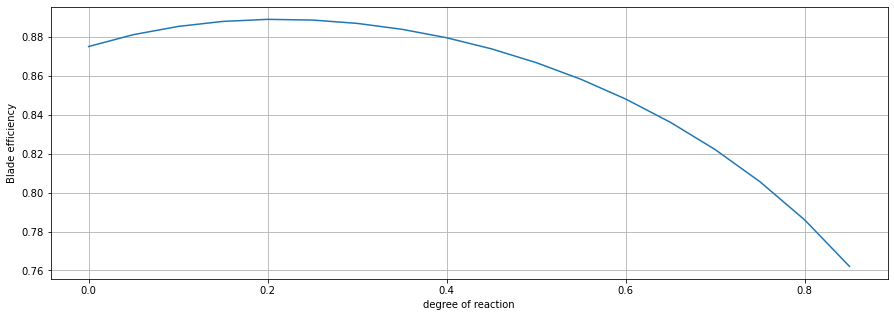

In [52]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(degree_of_reaction, eff)
ax.set_xlabel("degree of reaction")
ax.set_ylabel("Blade efficiency")
ax.grid();

# In module

In [50]:
from turbine_stage import TurbineStage

In [15]:
degree_of_reaction = np.arange(0, 0.9, 0.05)
p0 = np.ones_like(degree_of_reaction) * 2.3 * MPa


stage = TurbineStage(
    mass_flow_rate=G,
    average_diameter=d,
    inlet_pressure=p0,
    inlet_temperature=t0,
    outlet_pressure=p2,
    inlet_speed=0,
    degree_of_reaction=degree_of_reaction,
    overlapping=dl,
    rotation_speed=n,
    stator_outlet_angle=alpha_1_eff,
    is_last=True
)

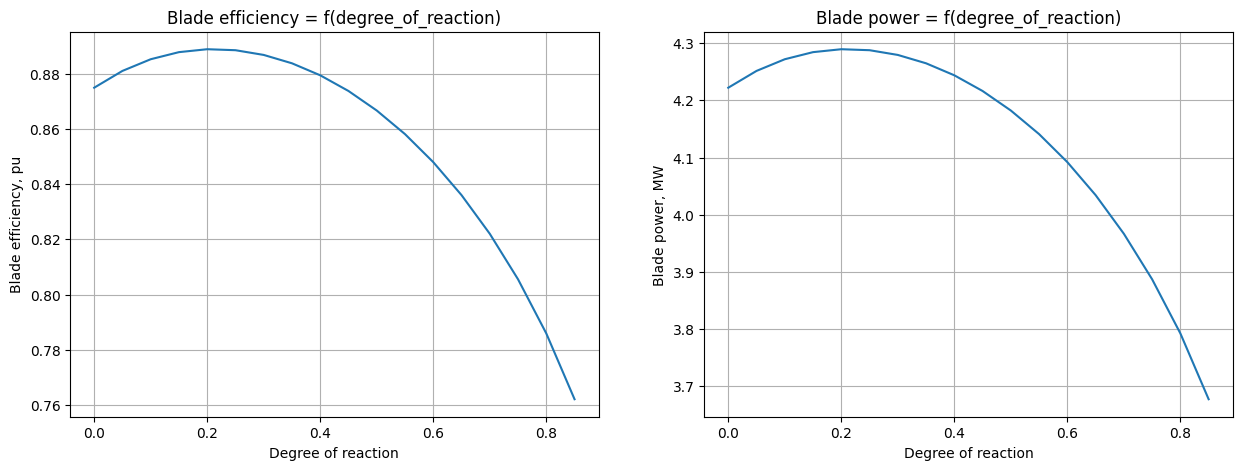

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(degree_of_reaction, stage.blade_efficiency)
ax[1].plot(degree_of_reaction, stage.blade_power / 1e6)
ax[0].set_title("Blade efficiency = f(degree_of_reaction)")
ax[0].set_xlabel("Degree of reaction")
ax[0].set_ylabel("Blade efficiency, pu")
ax[0].grid()

ax[1].set_title("Blade power = f(degree_of_reaction)")
ax[1].set_xlabel("Degree of reaction")
ax[1].set_ylabel("Blade power, MW")
ax[1].grid();

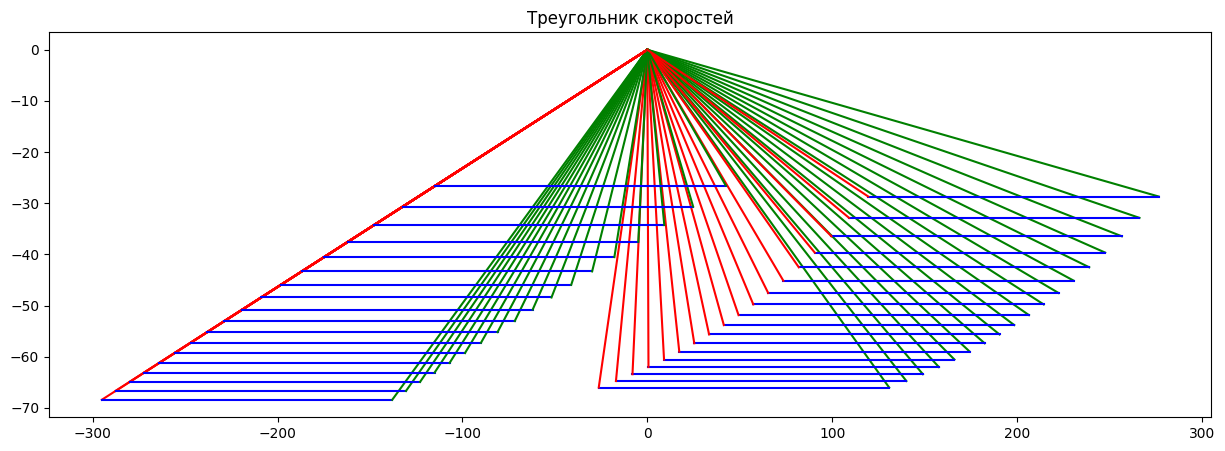

In [17]:
stage.triangles.plot()